In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')
%matplotlib inline

## Defining a Classifier

**Please run all cells before this cell, including the import cell at the top of the notebook.**

In [6]:
patients = pd.read_csv('breast-cancer.csv')
patients = patients.drop(columns='ID')
patients

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,0
679,2,1,1,1,2,1,1,1,1,0
680,5,10,10,3,7,3,8,10,2,1
681,4,8,6,4,3,4,10,6,1,1


**
Let's try to visualize the data as a cluster chart. What happens is that there are many data points with exact same X and Y values and they end up overlapping and get displayed as a single dot in the below chart. How can we distinguish between these data points so that they are displayed as a small cluster instead?
**

In [7]:
patients_class_0 = patients.groupby(by='Class').get_group((0))
patients_class_1 = patients.groupby(by='Class').get_group((1))

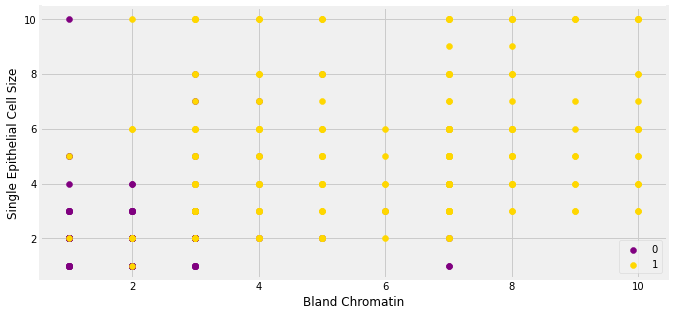

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(patients_class_0['Bland Chromatin'], patients_class_0['Single Epithelial Cell Size'], c='purple', label='0')
ax.scatter(patients_class_1['Bland Chromatin'], patients_class_1['Single Epithelial Cell Size'], c='gold', label='1')
ax.legend()
ax.set_xlabel('Bland Chromatin')
ax.set_ylabel('Single Epithelial Cell Size');

**
We can introduce a very tiny amount of random noise to each data point such that similar points don't overlap. Let's write a simple function! Note the RANDOMNESS of the noise being introduced on BOTH axes. 
**

In [9]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = pd.DataFrame({'Bland Chromatin (jittered)': 
        randomize_column(patients['Bland Chromatin']), 'Single Epithelial Cell Size (jittered)': 
        randomize_column(patients['Single Epithelial Cell Size']), 'Class': patients['Class']})

In [10]:
jittered_class_0 = jittered.groupby(by='Class').get_group((0))
jittered_class_1 = jittered.groupby(by='Class').get_group((1))

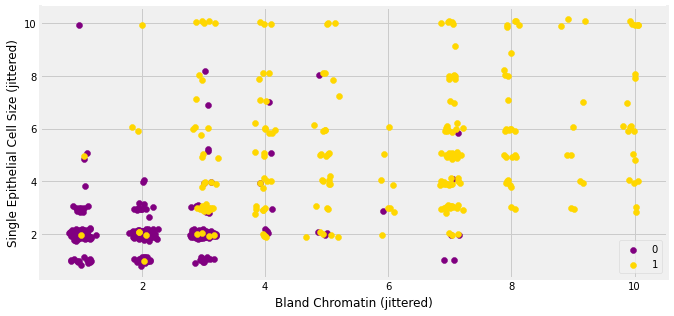

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(jittered_class_0['Bland Chromatin (jittered)'], jittered_class_0['Single Epithelial Cell Size (jittered)'], c='purple', label='0')
ax.scatter(jittered_class_1['Bland Chromatin (jittered)'], jittered_class_1['Single Epithelial Cell Size (jittered)'], c='gold', label='1')
ax.legend()
ax.set_xlabel('Bland Chromatin (jittered)')
ax.set_ylabel('Single Epithelial Cell Size (jittered)');

## Distance

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

** 
Given two points, how can we establish a measure for their "closeness"? Hint: calculate Eucledian distance between them!!
**

Formula: SQRT((x2-x1)^2 + (y2-y1)^2))



In [12]:
a_table = pd.DataFrame({'X': [0, 2, 3], 'Y': [0, 2, 4]})
a_table

,X,Y
0,0,0
1,2,2
2,3,4


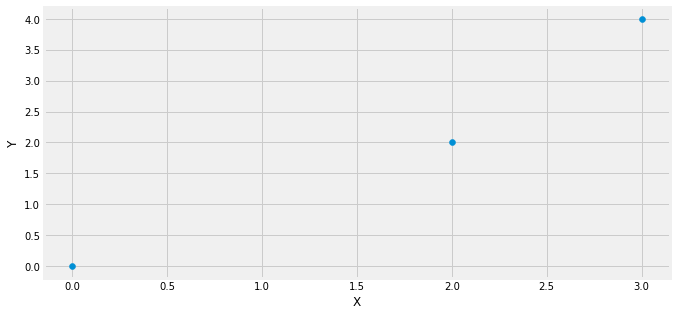

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(a_table['X'], a_table['Y'])
ax.set_xlabel('X')
ax.set_ylabel('Y');

In [14]:
def distance(row1, row2):
    """Return the distance between two points (represented as arrays)"""
    return np.sqrt(sum((row1 - row2) ** 2))

Training Set and Evaluation Set    
Giving a point to be classified, I have to compare it to the nearest one in the Training Set.

## Classification Procedure

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

**
General strategy : For a given (unseen) example, find the distance between this new observation and all the available observations (one at a time), then take the top K observations that are closest to this new observation (smaller the distance, closer the two observations) and lable the unseen example with the class that is the majority among the chosen K-nearest observations.
**

In [15]:
def distances(training, example):
    """Return the TRAINING table with an additional column of distances to EXAMPLE."""
    dists = np.array([])
    attributes = training.drop(columns='Class')
    for row in range(len(attributes.index)):
        training_row = np.array(attributes.iloc[row])
        dist = distance(training_row, example)
        dists = np.append(dists, dist)
    training['Distance'] = dists
    return training

In [13]:
def select_testing_training(table, nrows):
    """Return a training TABLE with NROWS."""
    testing_index = []
    training_index = table.sample(n=600).index
    for index in table.index:
        if index not in training_index:
            testing_index.append(index)
    testing_index = pd.Index(testing_index)
    return testing_index, training_index

In [14]:
testing_index , training_index = select_testing_training(patients, 600)

In [15]:
testing_table = patients.iloc[testing_index]
testing_table

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
7,2,1,2,1,2,1,3,1,1,0
13,1,1,1,1,2,3,3,1,1,0
23,1,1,1,1,2,1,3,1,1,0
31,10,7,7,3,8,5,7,4,3,1
37,5,4,4,9,2,10,5,6,1,1
...,...,...,...,...,...,...,...,...,...,...
656,2,1,1,1,2,1,3,1,1,0
661,5,1,1,1,2,1,1,1,1,0
665,5,10,10,10,4,10,5,6,3,1
666,5,1,1,1,2,1,3,2,1,0


In [16]:
training_table = patients.iloc[training_index]
training_table

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
388,5,3,3,1,2,1,2,1,1,0
264,3,3,5,2,3,10,7,1,1,1
418,3,2,2,3,2,1,1,1,1,0
140,1,1,1,1,2,5,1,1,1,0
52,10,5,5,6,8,8,7,1,1,1
...,...,...,...,...,...,...,...,...,...,...
157,3,1,1,1,2,1,3,1,1,0
253,5,10,10,6,10,10,10,6,5,1
588,5,4,6,8,4,1,8,10,1,1
436,5,1,1,1,2,1,1,1,1,0


In [17]:
example = np.array(testing_table.drop(columns='Class').iloc[0])
example

array([2, 1, 2, 1, 2, 1, 3, 1, 1], dtype=int64)

In [18]:
training_distances  = distances(training_table, example)
training_distances

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
388,5,3,3,1,2,1,2,1,1,0,3.872983
264,3,3,5,2,3,10,7,1,1,1,10.630146
418,3,2,2,3,2,1,1,1,1,0,3.162278
140,1,1,1,1,2,5,1,1,1,0,4.690416
52,10,5,5,6,8,8,7,1,1,1,14.662878
...,...,...,...,...,...,...,...,...,...,...,...
157,3,1,1,1,2,1,3,1,1,0,1.414214
253,5,10,10,6,10,10,10,6,5,1,20.346990
588,5,4,6,8,4,1,8,10,1,1,13.892444
436,5,1,1,1,2,1,1,1,1,0,3.741657


In [19]:
training_distances.sort_values(by='Distances', asc)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
388,5,3,3,1,2,1,2,1,1,0,3.872983
264,3,3,5,2,3,10,7,1,1,1,10.630146
418,3,2,2,3,2,1,1,1,1,0,3.162278
140,1,1,1,1,2,5,1,1,1,0,4.690416
52,10,5,5,6,8,8,7,1,1,1,14.662878
...,...,...,...,...,...,...,...,...,...,...,...
157,3,1,1,1,2,1,3,1,1,0,1.414214
253,5,10,10,6,10,10,10,6,5,1,20.346990
588,5,4,6,8,4,1,8,10,1,1,13.892444
436,5,1,1,1,2,1,1,1,1,0,3.741657


In [22]:
def closest(training, example, k):
    """Return a table of the k closest neighbors to example"""
    return distances(training, example).sort_values('Distance', ascending=True).head(k)

In [25]:
distances(training_table, example)

ValueError: operands could not be broadcast together with shapes (10,) (9,) 

In [ ]:
np.array(patients.iloc[12])

In [ ]:
example = np.array(patients.drop(columns='Class').iloc[12])
example

In [ ]:
distance(pat)

In [ ]:
closest(patients, example, 5)

In [ ]:
closest(patients.exclude(12), example, 5)

#### CAREFUL!! As seen above, this method will also include the example data point as its own nearest neighbor, with a distance of 0!! Should we inlcude it in the overall prediction? If yes, why? If not, why not????? Not sure.

In [ ]:
def majority_class(neighbors):
    """Return the class that's most common among all these neighbors."""
    return neighbors.group('Class').sort('count', descending=True).column('Class').item(0)

In [ ]:
def classify(training, example, k):
    "Return the majority class among the k nearest neighbors."
    nearest_neighbors = closest(training, example, k)
    return majority_class(nearest_neighbors)

In [ ]:
classify(patients.exclude(12), example, 5)

## Evaluation

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

**
How can we validate that our classifier is "good"? We set aside a small portion of the given data as our test set, use remaining data to train our classifier and then test the classifier on our test set. A good measure of accuracy for our classifier will be the number of examples it predicted correctly in test set (meaning Predicted Value == Actual value).
**

In [ ]:
patients.num_rows

In [ ]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

In [ ]:
def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        # Run the classifier on the ith patient in the test set
        test_patient = test_attributes.row(i)
        c = classify(training, test_patient, k)
        # Was the classifier's prediction correct?
        if c == test.column('Class').item(i):
            num_correct = num_correct + 1
    return num_correct / test.num_rows

In [ ]:
evaluate_accuracy(training_set, test_set, 5)

In [ ]:
evaluate_accuracy(training_set, test_set, 1)

In [ ]:
evaluate_accuracy(training_set, training_set, 1)

#### As we saw in the above cell, a 1-nearest neighbor classifier when tested on the training data itself will show 100% accuracy (of course it will! A data point is closest to itself after all!!). But that's very misleading and wrong! Never do that!!!

## Decision Boundaries

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

In [ ]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

In [ ]:
kidney = ckd.select('Hemoglobin', 'Glucose', 'Class')
kidney.scatter('Hemoglobin', 'Glucose', colors=2)
plots.scatter(13, 250, color='red', s=30);

In [ ]:
def show_closest(t, point):
    """Show closest training example to a point."""
    near = closest(t, point, 1).row(0)
    t.scatter(0, 1, colors='Class')
    plots.scatter(point.item(0), point.item(1), color='red', s=30)
    plots.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)], color='k', lw=2)
    
show_closest(kidney, make_array(13, 250))

**In the above chart, the point chosen as nearest is NOT ACTUALLY the nearest one (as we can visually confirm)! Why did that happen? It happened because the X and Y axes are at a different scale. The formula for calculating Eucledian distance is based on the difference between X as well as Y axes. In this case, for a relatively small change in X value around the example (red) point, Y changes significantly. Hence, the point with the OVERALL lowest distance is chosen (incorrectly) as the nearest one.
**

#### How can we fix this? Convert your data into STANDARD UNITS!!


In [ ]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

In [ ]:
kidney_su = standardize(kidney.drop('Class')).with_column('Class', kidney.column('Class'))
show_closest(kidney_su, make_array(-0.2, 1.8))

In [ ]:
show_closest(kidney_su, make_array(-0.2, 1.3))

In [ ]:
show_closest(kidney_su, make_array(-0.2, 1))

In [ ]:
show_closest(kidney_su, make_array(-0.2, 0.9))

**
How to draw the decision boundary? <br><br>
Method: Imagine every possible data point on the chart as an (x,y) pair. We use these points to draw a scatter chart and color it based on the predicted values first (light blue and light yellow). We'll get a nice separation between the two clusters and that's the decision boundary. Then we overlay the actual values (dark blue and dark yellow)  on top of this filled-out scatter plot to vislauize how the actual data looks. Changing the K-value will show a different decision boundary. Some will be smoother (more generalized) than the others (more edges/squiggly). More generalized ones are the goal for better predictions.
**

In [ ]:
def decision_boundary(t, k):
    """Decision boundary of a two-column + Class table."""
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class')) # Can't standardize class, so exclude.
    decisions = Table(t_su.labels)
    for x in np.arange(-2, 2.1, 0.1):
        for y in np.arange(-2, 2.1, 0.1):
            predicted = classify(t_su, make_array(x, y), k)
            decisions.append([x, y, predicted])
    decisions.scatter(0, 1, colors='Class', alpha=0.4)
    plots.xlim(-2, 2)
    plots.ylim(-2, 2)
    t_su_0 = t_su.where('Class', 0)
    t_su_1 = t_su.where('Class', 1)
    plots.scatter(t_su_0.column(0), t_su_0.column(1), c='darkblue', edgecolor='k')
    plots.scatter(t_su_1.column(0), t_su_1.column(1), c='gold', edgecolor='k')
    
decision_boundary(kidney, 1)

In [ ]:
decision_boundary(kidney, 5)

In [ ]:
decision_boundary(jittered, 1)

In [ ]:
decision_boundary(jittered, 5)